In [14]:
import py21cmcast as p21c
import numpy as np 

from astropy import units

%matplotlib inline

## I. Create the configuration files for varying parameters

See the examples of master configuration files in the config folder. Running **init\_fisher\_from\_fiducial** will create a folder (named after the run name set in the master configuration file) and sub configuration files inside (which correspond to the variation of each parameter). Once they are created each can by run with the script [**run\_fisher.py**](https://github.com/gaetanfacchinetti/21cmCAST/blob/main/scripts/exec/run_fisher.py). Note that the script takes at least one argument (the name of the sub configuration files to run) and three optional: the number of threads, the number of the first seed, and the number of times the same script should be run with increasing seeds. The latter is only usefull to run several fiducial cases in order to determine what the 'average Universe' looks like. In practice, for a Fisher forecast one should fix the seed to a single value for all the runs. 

In [ ]:
configuration_file = "example_wdm.config"
p21c.init_runs(configuration_file, clean_existing_dir=False)

## II. Define the grid of modes and redshifts

Let us call the function **define\_grid\_modes\_redshits()**. It returns the bin edges for a fixed grid of modes and redshifts.

- The redshift bins are computed from the frequency according to the formula
\begin{equation}
z_n \equiv \frac{f_{21}}{\frac{f_{21}}{1+z_0} - n B} -1
\end{equation}
where $B$ is the bandwidth and $f_{21}$ is the 21cm frequency.

- The mode bins are computed from the bandwidth according to the formula
\begin{equation}
k_n \equiv {\rm max} \left\{k_{\rm min},  \delta k \right\} + n \delta k \quad {\rm with} \quad \delta k \equiv 2\pi \frac{f_{21}}{B} \frac{H(z_0)}{c(1+z_0)^2}
\end{equation}
This definition corresponds to the bins set by **21cmSense**. Note that the choice of redshift $z_0$ fixes the step of the mode bins.

In [2]:
z_bins, z_array, k_bins = p21c.define_grid_modes_redshifts(6., 8 * units.MHz, z_max = 22, k_min = 0.1 / units.Mpc, k_max = 1 / units.Mpc)
print("The redshift bin edges are:", z_bins)
print("The mode bin edges are:", k_bins)

The redshift bin edges are: [ 6.          6.28730456  6.5992025   6.93899281  7.31059216  7.71868653
  8.16892985  8.66820756  9.22499121  9.84982306 10.55599    11.36047883
 12.28536057 13.35984643 14.62342929 16.13084378 17.96020444 20.22698157]
The mode bin edges are: [0.1        0.15329426 0.20658851 0.25988277 0.31317703 0.36647129
 0.41976554 0.4730598  0.52635406 0.57964831 0.63294257 0.68623683
 0.73953109 0.79282534 0.8461196  0.89941386 0.95270811] 1 / Mpc


## III. Define the fiducial model and get its power spectrum

A **Fiducial** object can be defined by specifying the path where the lightcones are saved (depends on what was set on the config file) as well as  the redshifts and modes bin edges. Note that we must set by hand whether the mode bins are linearly of logarithmically spaced with the option **logk**  that is by default **False** as the output mode bin deges returned by **define\_grid\_modes\_redshits()** are linearly spaced. Further options can be specified, such as a fraction of modeling error **frac\_mod** (see below).

In [6]:
fiducial = p21c.Fiducial("/globalscratch/ulb/physth_fi/gfacchin/wdm_21cm/output/WDM_FISHER/WDM_7.0_0_MINIHALOS", z_bins, z_array, k_bins, False, load=True)

## IV. Evaluate experimental noise

The experimental noise is derived using **21cmSense**. To that end one simply has to pass an 'observation_set' attribute to the compute_sensitivity() method of the fiducial object. If none are passed the default is used `default_HERA`. To use a custom instrument create a list of 21cmSense Observations objects the length of 'fiducial.z_array' (each observation corresponding to the redshift in `fiducial.z_array`).

In [7]:
fiducial.compute_sensitivity()

Successfully loaded sensitivity for  default_HERA


## V. Define the Parameter objects

(This part is the longest and can take minutes or hours depending on the box resolution). Here all power spectra and associated derivatives are pre-computed and stored as atrribute of the **Parameter** object. With the load and save options of the **Parameter** class, if this part of code has been executed once, then all the objects can be reloaded in an instant (since every pre-computed quantity is stored in .npz and .pkl files).

### 1. Astrophysical parameters

In [8]:
## Classical set of parameters
parameter_names = ['F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI', 't_STAR','F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH']

params = [None] * len(parameter_names)

for iname, name in enumerate(parameter_names) :  
    try:
        params[iname] = p21c.Parameter(fiducial=fiducial, name=name, verbose = False, plot = False, load=True)
    except Exception as e:
        print("Problem with: ", name)
        print(e)
        pass

Treating parameter F_STAR10
Treating parameter F_STAR7_MINI
Treating parameter ALPHA_STAR
Treating parameter ALPHA_STAR_MINI
Treating parameter t_STAR
Treating parameter F_ESC10
Treating parameter F_ESC7_MINI
Treating parameter ALPHA_ESC
Treating parameter L_X
Treating parameter L_X_MINI
Treating parameter NU_X_THRESH


### 2. Including WDM (or any other parameter)

We define an array of parameter objects corresponding to M_WDM for many different step sizes around the central/fiducial value (given in percentage of the fiducial value). This part (especially for a large number of steps) can be long up to a few hours.

In [ ]:
# This sequence of step should be the same as the one given in the .config file in the section [cosmo_params_vary] for M_WDM

steps = np.array([ 1.        ,  1.0277316 ,  1.05623224,  1.08552325,  1.11562654, 1.14656465,  1.17836072,  1.21103855,  1.24462259,  
                          1.27913796, 1.3146105 ,  1.35106675,  1.38853399,  1.42704026,  1.46661437, 1.50728593,  1.54908538,  1.59204399,  
                          1.63619392,  1.68156819, 1.72820077,  1.77612654,  1.82538137,  1.87600211,  1.92802665, 1.98149391,  2.03644391,  
                          2.09291775,  2.15095771,  2.2106072 , 2.27191088,  2.3349146 ,  2.39966551,  2.46621207,  2.53460408, 2.6048927 ,  
                          2.67713054,  2.75137165,  2.82767159,  2.90608744, 2.98667789,  3.06950325,  3.15462548,  3.24210829,  3.33201714, 
                          3.4244193 ,  3.51938392,  3.61698207,  3.71728676,  3.82037307, 3.92631812,  4.0352012 ,  4.14710378,  4.2621096 ,  
                          4.38030471, 4.50177757,  4.62661906,  4.7549226 ,  4.88678421,  5.02230255, 5.16157903,  5.30471787,  5.45182618,  
                          5.60301403,  5.75839457, 5.91808406,  6.082202  ,  6.25087118,  6.42421783,  6.60237167, 6.78546599,  6.97363781,  
                          7.16702794,  7.36578108,  7.57004597, 7.77997545,  7.99572661,  8.21746089,  8.44534422,  8.67954712, 8.92024484,  
                          9.16761749,  9.42185019,  9.68313316,  9.95166192, 10.22763742, 10.51126616, 10.80276038, 11.10233819, 11.41022379, 
                          11.72664754, 12.05184622, 12.38606319, 12.72954852, 13.08255926, 13.44535955, 13.81822086, 14.20142222, 14.59525037, 15.])

# adding extra parameters
len_s        = len(steps)
mwdm_array   = np.zeros((len_s, 2))
extra_params = np.full(shape=(len_s), fill_value=None)

for iv, v in enumerate(steps):
    
    try:
        mwdm_array[iv, :] = fiducial.cosmo_params['M_WDM'] * (1 - np.array([-1, +1])/100 * v)
        extra_params[iv] = p21c.Parameter(fiducial=fiducial, name='M_WDM', verbose = False, plot=False, load=True, values = list(mwdm_array[iv, :]))    
    except Exception as e:
        # Sometimes some runs do not complete, we can forget about them
        print("M_WDM -> problem at p = ", v, "% :", mwdm_array[iv, :])
        print(e)
        pass


## VI. Evaluate the Fisher matrix and its inverse

From the list of parameters objects defined above one can directly compute the Fisher matrix with the **evaluate\_fisher\_matrix()** function. One can add a modeling noise to the power spectrum with the attribute **frac\_noise** of the fiducial (as a percentage of the fiducial value). The triangle plot figure can be produced with the function **make\_triangle\_plot()** and plotted. Finally, the matrices can be displayed nicely with the **display\_matrix()** function.

### 1. Without extra parameters

In [38]:
fisher_matrix     = p21c.evaluate_fisher_matrix(params)
covariance_matrix = np.linalg.inv(fisher_matrix['matrix'])

# note that here we approximate the covariance matrix as the inverse Fisher which is not exactly true

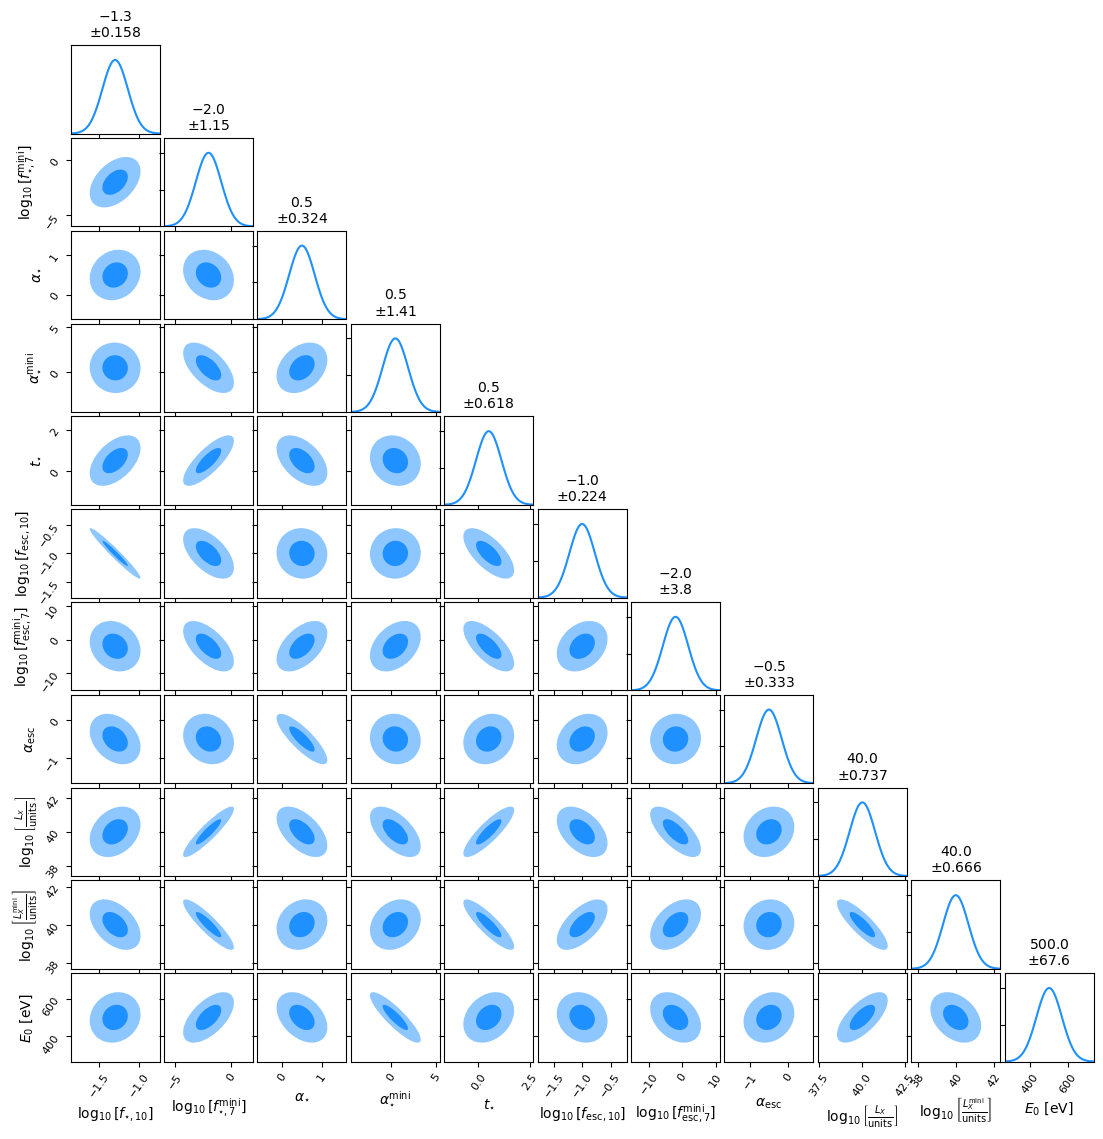

In [39]:
covariance_dict = {}

# Transform the covariance matrix into covariance dictionnaries that can be plotted

for i, name_i in enumerate(fisher_matrix['name']):
    covariance_dict[name_i] = {}
    for j, name_j in enumerate(fisher_matrix['name']):
        covariance_dict[name_i][name_j] = covariance_matrix[i, j]

fig = p21c.make_triangle_plot([covariance_dict], [fiducial.astro_params], color=['dodgerblue'], alpha=[1], 
                              params_to_plot = ['F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI',  't_STAR', 'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH'])

fig.savefig(fiducial.dir_path + '/triangle_plot.pdf');

### 2. With extra parameters

In [45]:
sigma  = np.zeros(shape=(len(mwdm_array)))

mask = [True] * len(params)
for ip, param in enumerate(params):
    if param is None:
        mask[ip] = False

n = len([*(np.array(params)[mask])]) +1
covariance_matrix     = np.zeros((len(steps), n, n))

for im, inv_mwdm in enumerate(steps) : 
    if extra_params[im] is not None:
        fisher_matrix     = p21c.evaluate_fisher_matrix([*(np.array(params)[mask]), extra_params[im]])
        try: 
            covariance_matrix[im, :, :] = np.linalg.inv(fisher_matrix['matrix'])
            sigma[im] = np.sqrt(covariance_matrix[im][-1][-1])
        except:
            print([*(np.array(params)[mask]), extra_params[im]])
            print(fisher_matrix)

fisher_matrix_fid     = p21c.evaluate_fisher_matrix(np.array(params)[mask])
covariance_matrix_fid = np.linalg.inv(fisher_matrix_fid['matrix'])

sigma[sigma == 0] = np.nan
steps[sigma == 0] = np.nan

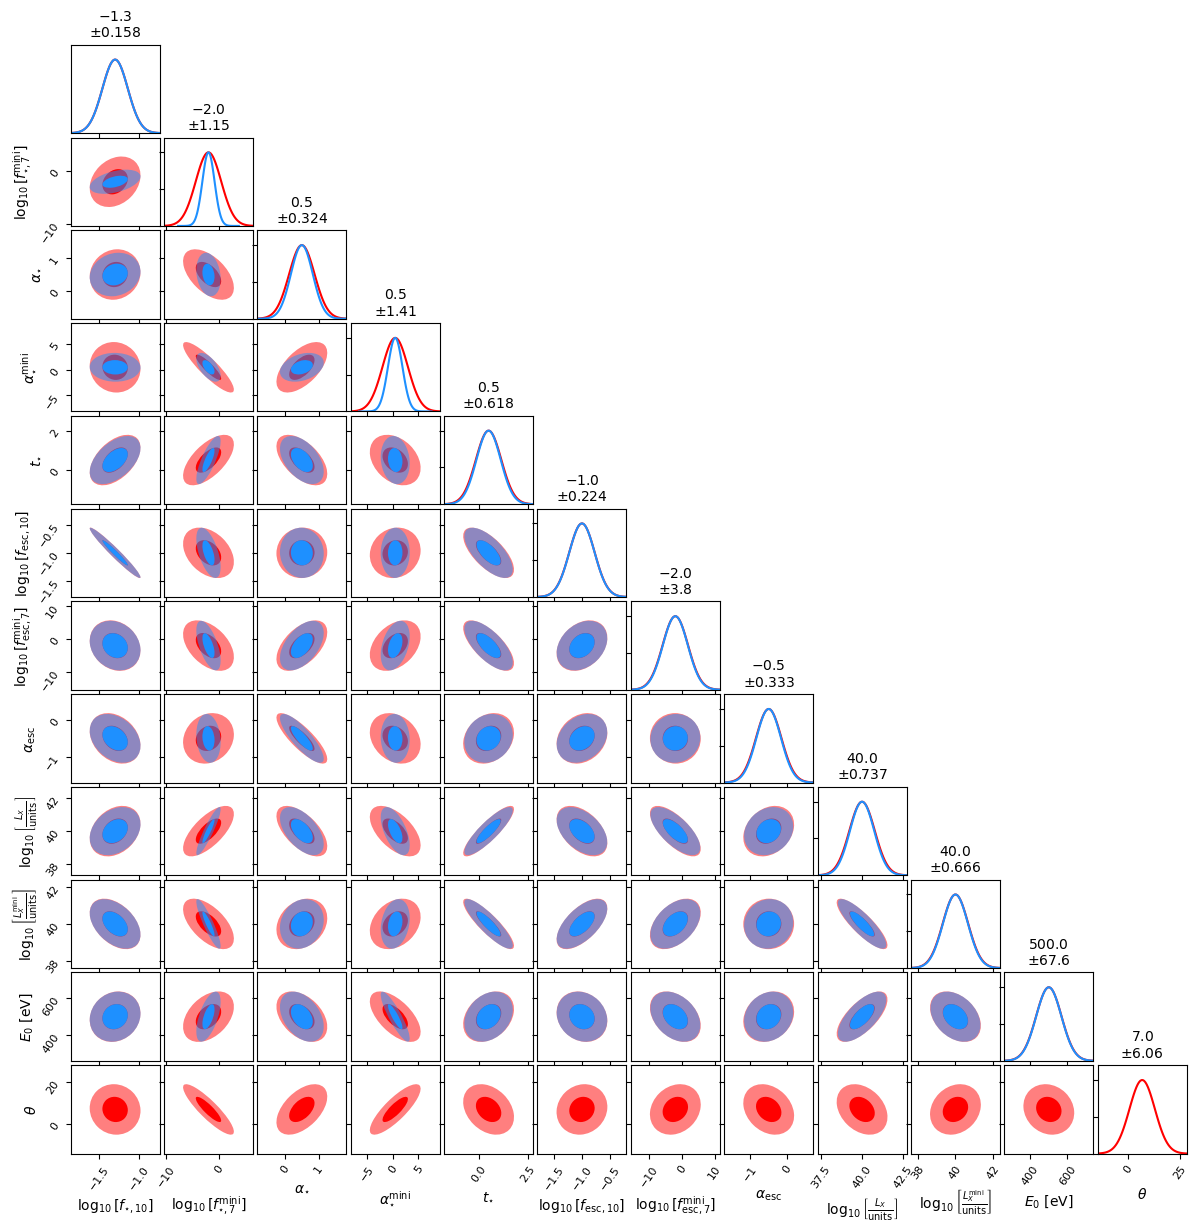

In [48]:
fid = (fiducial.astro_params | fiducial.cosmo_params)

cov_dict={}
cov_dict_check={}
fid_dict={}

all_params = parameter_names + ['M_WDM']


for ip, pi in enumerate(all_params):

    cov_temp = {pj:covariance_matrix[69, ip, jp] for jp, pj in enumerate(all_params)}
    cov_dict[pi] = cov_temp 


for ip, pi in enumerate(all_params[:-1]):

    cov_temp_check = {pj:covariance_matrix_fid[ip, jp] for jp, pj in enumerate(all_params[:-1])}
    cov_dict_check[pi] = cov_temp_check

fig = p21c.make_triangle_plot([cov_dict, cov_dict_check], [fid, fid], 
                   color=['r', 'dodgerblue'], 
                   alpha=[1, 1], rax=True,
                   params_to_plot = all_params)

fig.savefig(fiducial.dir_path + '/triangle_plot.pdf');


With extra parameters we can plot the value of the error that parameters according to the step size. This is necessary to identify a "plateau" where the error is independant on the step size (as it should be if we could exactly compute the derivative in the Fisher matrix elements).

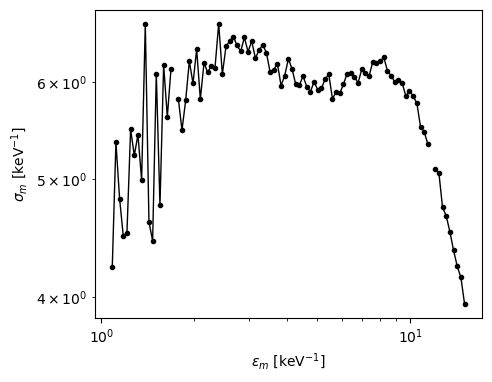

In [43]:
fig, ax = p21c.prepare_plot(ylog=True, xlog=True, xlabel=r'$\epsilon_{m}  ~ [{\rm keV^{-1}}]$', ylabel=r'$\sigma_{m} ~ [{\rm keV}^{-1}]$')
ax.plot(steps,  sigma, marker='o', linestyle = '-', color='k', linewidth=1, markersize=3)